In [1]:
import gzip
import pickle
import struct

import matplotlib.pyplot as plt
import numpy as np
from array import array as pyarray

import pandas as pd
from scipy.ndimage import interpolation
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.datasets import mnist, cifar100, cifar10, fashion_mnist

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


2022-05-05 18:06:56.449991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 18:06:56.450008: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

def compute_mean(X):
    npX = np.array(X)
    length = npX.shape[0]
    sum_x = np.sum(npX[:, 0])
    sum_y = np.sum(npX[:, 1])
    return [sum_x / length, sum_y / length]


def sse(X, C):
    _c = np.array(C)
    m = (1.0 / len(X))
    return m * np.sum(np.array([np.abs(x - _c) * np.abs(x - _c) for x in X]))


def bkmeans(X, k=2, iter=10):
    """
    :param X:
    :param y:
    :return: array of indices.
    """
    clusters = []
    minSSE = np.inf
    labels = None
    centroid = None

    for it in range(iter):
        kmean = KMeans(n_clusters=2, n_jobs=-1, random_state=True)
        kmean.fit(X)
        SSE = kmean.inertia_
        if SSE < minSSE:
            minSSE = SSE
            labels = kmean.labels_
            centroid = kmean.cluster_centers_

    assert len(labels) == len(X)

    xl = [i for i, l in enumerate(labels) if l == 0]  # X indices
    x_l = [X[l] for l in xl]  # Cached X
    _sse = sse(np.array(x_l), centroid[0])
    clusters.append([_sse, centroid[0], xl, x_l, 0])

    xr = [i for i, l in enumerate(labels) if l == 1]  # X indices
    x_r = [X[l] for l in xr]  # Cached X
    _sse = sse(x_r, centroid[1])
    clusters.append([_sse, centroid[1], xr, x_r, 1])

    while len(clusters) < k:
        maxIndex = 0
        maxSSE = -1
        # Choose the cluster with Maximum SSE to split
        for j in range(len(clusters)):
            SSE = clusters[j][0]
            if SSE > maxSSE:
                maxIndex = j
                maxSSE = SSE

        minSSE = np.inf
        labels = None
        centroid = None

        # Select the cluster to split.
        selectedSplitCluster = clusters[maxIndex]
        pointsInCluster = selectedSplitCluster[3]
        for it in range(iter):
            kmean = KMeans(n_clusters=2, n_jobs=-1, random_state=True)
            kmean.fit(pointsInCluster)
            SSE = kmean.inertia_
            if SSE < minSSE:
                minSSE = SSE
                labels = kmean.labels_
                centroid = kmean.cluster_centers_

        clusterIndex = selectedSplitCluster[2]

        # Update the index on the left side.
        xl = [i for i, l in zip(clusterIndex, labels) if l == 0]  # X indices
        # Update cached feature variables.
        x_l = [X[l] for l in xl]
        _sse = sse(x_l, centroid[0])
        clusters[maxIndex] = [_sse, centroid[0], xl, x_l, maxIndex]

        # Update the index
        xr = [i for i, l in zip(clusterIndex, labels) if l == 1]  # X indices
        # Update cached feature variables.
        x_r = [X[l] for l in xr]
        _sse = sse(x_r, centroid[1])
        clusters.append([_sse, centroid[1], xr, x_r, maxIndex + 1])

    assert len(clusters) == k

    indices = np.zeros(len(X), dtype=np.int)
    for j, cluster in enumerate(clusters):
        x_indices = cluster[2]
        for l, i in enumerate(x_indices):
            indices[i] = int(j)

    assert len(indices) == len(X)
    return indices


In [3]:


def assertShape(sa, n):
    assert sa.shape[1] == 2 and sa.shape[0] == n


def sammon(X, max_iter, e=1e-4, rate=0.01):
    """
    E = 1 / sum(X distances) * sum( (X distances - Y distances)^2 / X distances)
    DE/Dy = (-2 / c) * sum [i = 1 j != p, ( X distance - Y Distance / X distance * Y distances)] ( y - y )
    c = sum(y distance i,j) i < j
    :param X: Extended matrix.
    :param max_iter:
    :param e:
    :param rate:
    :return:  n × 2
    """
    n = 2  # Dimensions.
    distX = cdist(X, X, 'euclidean')

    y = np.random.normal(0.0, 1.0, [X.shape[0], n])

    for it in range(max_iter):
        distY = cdist(y, y, 'euclidean')
        c = distX.sum() / 2.0

        # Compute E.
        e0 = 1.0 / c
        e1 = (distX - distY) ** 2.0
        e2 = distX
        # Divide while prevent divide by zero.
        E = e0 * np.divide(e1, e2, out=np.zeros_like(e1),
                           where=e1 != 0).sum() / 2.0

        print("E:", E)

        if E < e:
            return y

        # Prevent C from getting to small.
        if abs(c) < 0.0001:
            c = 0.01 * np.sign(c)
        coff = (-2.0 / c)
        for i in range(y.shape[0]):
            delta_0 = np.zeros(y.shape[1])
            delta_1 = np.zeros(y.shape[1])

            for j in range(y.shape[0]):
                if i == j:
                    continue

                # Compute shared variables.
                dpi_x = distX[i, j]
                dpi_y = distY[i, j]

                # Handle small denominator
                if abs(dpi_x) < 0.0001:
                    dpi_x = 0.01 * np.sign(dpi_x)
                if abs(dpi_y) < 0.0001:
                    dpi_y = 0.01 * np.sign(dpi_y)

                dpi_diff = (dpi_x - dpi_y)
                dpi_mul_inv = 1.0 / (dpi_x * dpi_y)
                ydiff = (y[i] - y[j])
                ydiffexp2 = ydiff ** 2

                # First derivative
                delta_0 = delta_0 + dpi_diff * dpi_mul_inv * ydiff

                # Second derivative
                delta1_v = (dpi_diff - ((ydiffexp2 / dpi_y)
                            * (1 + (dpi_diff / dpi_y))))
                delta_1 = delta_1 + dpi_mul_inv * delta1_v

            delta_0 = coff * delta_0
            delta_1 = coff * delta_1

            delta = delta_0 / np.absolute(delta_1)
            y[i] = y[i] - rate * delta

    if it == max_iter - 1:
        print("Warning: max_iter exceeded. Sammon mapping may not have converged...")

    assertShape(y, len(X))

    return y


In [4]:
def deskew(image):
    """
    https://fsix.github.io/mnist/Deskewing.html
    :param image:
    :return:
    """
    c, v = moments(image)
    alpha = v[0, 1] / v[0, 0]
    affine = np.array([[1, 0], [alpha, 1]])
    ocenter = np.array(image.shape) / 2.0
    offset = c - np.dot(affine, ocenter)
    return interpolation.affine_transform(image, affine, offset=offset)


In [5]:

def loadDataSet(nth=0, training_size=1000, testing_size=100):
    if nth == 0:
        (train_X, train_y), (test_X, test_y) = mnist.load_data()
        return train_X, train_y, test_X, test_y, "MNIST Digit"
    elif nth == 1:
        (trainX, trainy), (testX, testy) = fashion_mnist.load_data()
        return trainX, trainy, testX, testy, "MNIST Fashion"
    elif nth == 2:
        (trainX, trainy), (testX, testy) = cifar100.load_data()
        return trainX, trainy, testX, testy, "MNIST Fashion"
    elif nth == 3:
        (trainX, trainy), (testX, testy) = cifar10.load_data()
        return trainX, trainy, testX, testy, "MNIST Fashion"


In [6]:
# Check all datasets
def displaySampleData():
    plt.figure(figsize=(20, 4))
    for i in range(0, 4):
        X, y, tx, ty, name = loadDataSet(i, training_size=10, testing_size=1)
        for index, (image, label) in enumerate(zip(X[0:5], y[0:5])):
            p_ = plt.subplot(4, 5, (i * 5) + (index + 1))
            p_.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
            p_.set_title('Training: {}\n'.format(label), fontsize=20)
    plt.title("Example of data set elements")
    plt.suptitle("Examples")
    plt.show()


4431872/4422102 [==============================] - 0s 0us/step


ValueError: cannot reshape array of size 3072 into shape (28,28)

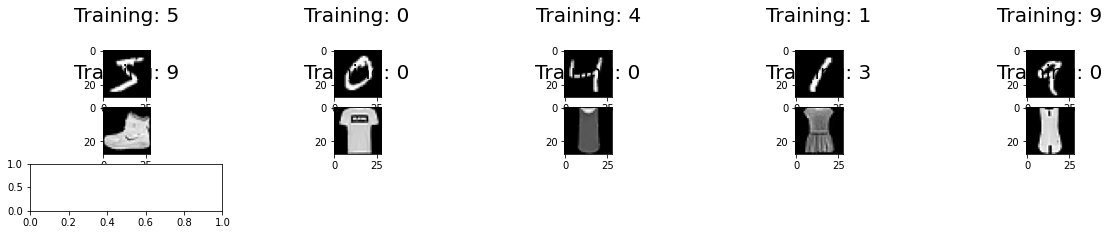

In [7]:
displaySampleData()


In [ ]:

drPickles = ['{}_DR_model.sav'.format(i) for i in range(0, 10)]
ClusterPickles = ['{}_CL_model.sav'.format(i) for i in range(0, 10)]

# DR techniques
for i in range(0, 3):  # Iterate data sets.
    X, y, tx, ty, name = loadDataSet(i, 500, 50)
    n_samples = len(X)
    n_features = len(X[0])

    print("Starting on dataset '{}'".format(name))
    for j in range(0, 3):  # Iterate DR techniques.
        filename = drPickles[i * 3 + j]
        plti = plt.subplot(3, 3, (i * 3) + j + 1)
        if j == 0:  # PCA

            # Generate new PCA or load.
            try:
                with open(filename, 'rb') as f:
                    pca = pickle.load(f)
            except FileNotFoundError as f:
                n_components = min(n_samples, n_features)
                pca = PCA(n_components=3)
                pca.fit(X, y)
                pickle.dump(pca, open(filename, 'wb'))

            pca_result = pca.transform(X)
            ax = plti

            pca0 = pca_result[:, 0]
            pca1 = pca_result[:, 1]
            pca2 = pca_result[:, 2]

            ax.scatter(
                x=pca0, y=pca1,
                c=y,
                alpha=0.3)
            ax.set_xlabel('PCA-one')
            ax.set_ylabel('PCA-two')
            plti.set_title("PCA - {}".format(name))

        elif j == 1:  # t-SNE
            colors = ['r', 'g', 'b', 'c', 'm',
                      'y', 'k', 'w', 'orange', 'purple']

            # Generate new t-SNE or load.
            try:
                with open(filename, 'rb') as f:
                    tsne = pickle.load(f)
            except FileNotFoundError as f:
                tsne = TSNE(n_components=2, random_state=0,
                            verbose=1, perplexity=40, n_iter=300)
                tsne.fit(X)
                pickle.dump(tsne, open(filename, 'wb'))

            tsne_results = tsne.fit_transform(X)
            tsne0 = tsne_results[:, 0]
            tsne1 = tsne_results[:, 1]

            target_ids = range(len(y))
            for _i, label in zip(target_ids, y):
                plti.scatter(x=tsne0, y=tsne1,
                             c=y,
                             alpha=0.3)
            plti.set_title("t-SNE - {}".format(name))

        elif j == 2:  # Sammon mapping.
            result = sammon(X, 250, 0.035, 0.1)
            sammon0 = result[:, 0]
            sammon1 = result[:, 1]
            plti.scatter(x=sammon0, y=sammon1,
                         c=y,
                         alpha=0.3)
            plti.set_title("Sammon mapping - {}".format(name))

plt.title("Dimension Reduction")
plt.suptitle("Dimension Reduction")
plt.show()

# Cluster techniques
# Bisecting k-Means with classic k-Means and hierarchical clustering for each data set
for i in range(0, 3):
    X, y, tx, ty, name = loadDataSet(i)
    pcaModelFilePath = ClusterPickles[i]
    k = 5
    try:
        with open(pcaModelFilePath, 'rb') as f:
            pca = pickle.load(f)
    except Exception as err:
        pca = PCA(n_components=2)
        pca.fit(X)
        pickle.dump(pca, open(pcaModelFilePath, 'wb'))

    pca_result = pca.fit_transform(X)
    #pca_test = pca.transform(tx)

    pca0 = pca_result[:, 0]
    pca1 = pca_result[:, 1]

    for j in range(0, 3):
        plti = plt.subplot(3, 3, i * 3 + j + 1)
        if j == 0:
            plti.set_title("Hierarchical Clustering - {}".format(name))
            clus = AgglomerativeClustering(n_clusters=k)
            clus.fit(pca_result, y)
            plti.scatter(x=pca0, y=pca1, c=clus.labels_, alpha=0.3)
            #l = clus.fit_predict(pca_test)
        elif j == 1:
            plti.set_title("K Mean - {}".format(name))
            kmean = KMeans(n_jobs=-1, n_clusters=k, random_state=True)
            kmean.fit(pca_result, y)
            plti.scatter(x=pca0, y=pca1, c=kmean.labels_, alpha=0.3)
        elif j == 2:
            plti.set_title("Bisecting K Mean - {}".format(name))
            labels = bkmeans(pca_result, k, 30)
            plti.scatter(x=pca0, y=pca1, c=labels, alpha=0.3)

plt.title("Cluster Reduction")
plt.suptitle("Cluster Reduction")
plt.show()
